# AR/MA

In [58]:
import ts_utils
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

# EDA: Exploratory Data Analysis

In [ ]:
# pip install gcsfs
weather = pd.read_csv("gs://resources-gdm/weather.csv", index_col=0)

In [13]:
# Los índices son strings
weather.index.dtype

dtype('O')

In [17]:
# Hacemos un "casting" de strings a fechas
weather.index = pd.to_datetime(weather.index)
weather.index.dtype

dtype('<M8[ns]')

In [21]:
weather.dtypes

dia             int64
mes             int64
anno            int64
temp_max      float64
temp_min      float64
temp_media    float64
htemp_max      object
htemp_min      object
hum_max       float64
hum_min       float64
hhum_max       object
hhum_min       object
pres_max      float64
pres_min      float64
pres_media    float64
hpres_max      object
hpres_min      object
rad_max       float64
rad_min       float64
hrad_max      float64
hrad_min      float64
vv_max        float64
vv_media      float64
rachas_max    float64
hvv_max        object
lluvia        float64
dtype: object

In [26]:
# min_x f(x)
weather["temp_media"].min()

15.0

In [30]:
# arg min_x f(x)
weather["temp_media"].idxmin()

Timestamp('1989-12-24 00:00:00')

In [31]:
# max_x f(x)
weather["temp_media"].max()

36.0

In [32]:
# arg max_x f(x)
weather["temp_media"].idxmax()

Timestamp('1982-05-28 00:00:00')

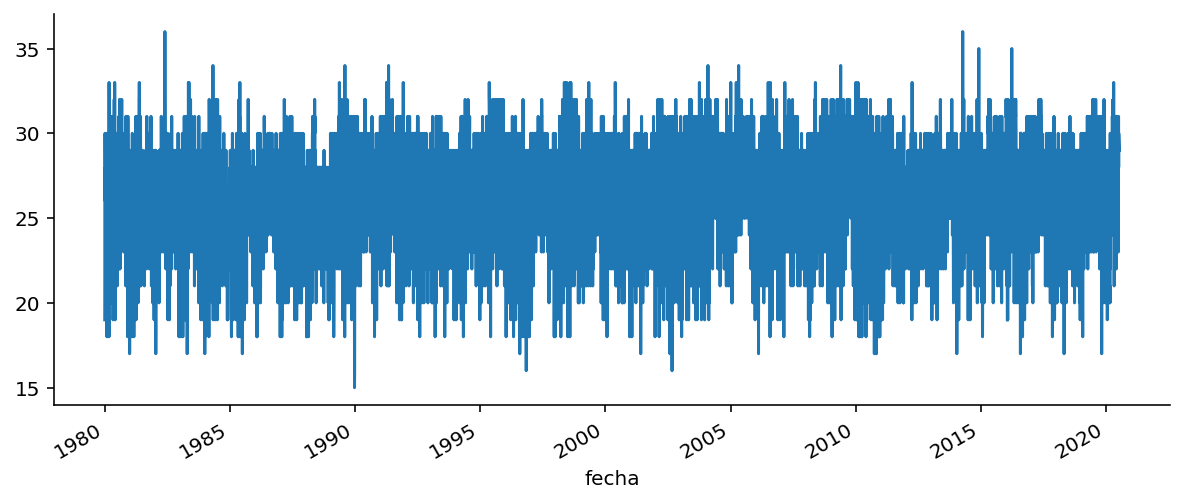

In [24]:
weather["temp_media"].plot()

## Analizando la temperatura media semanal

In [36]:
# Agrupamos los datos semanalmente y calculamos su promedio
temp_media = weather["temp_media"].resample("W").mean()
# Partimos los datos entre datos de entrenamiento y datos de prueba (train / test)
# 70/80 entrenamiento || 30 / 20 de prueba
temp_media_train, temp_media_test = temp_media[:"2019"], temp_media["2020":]

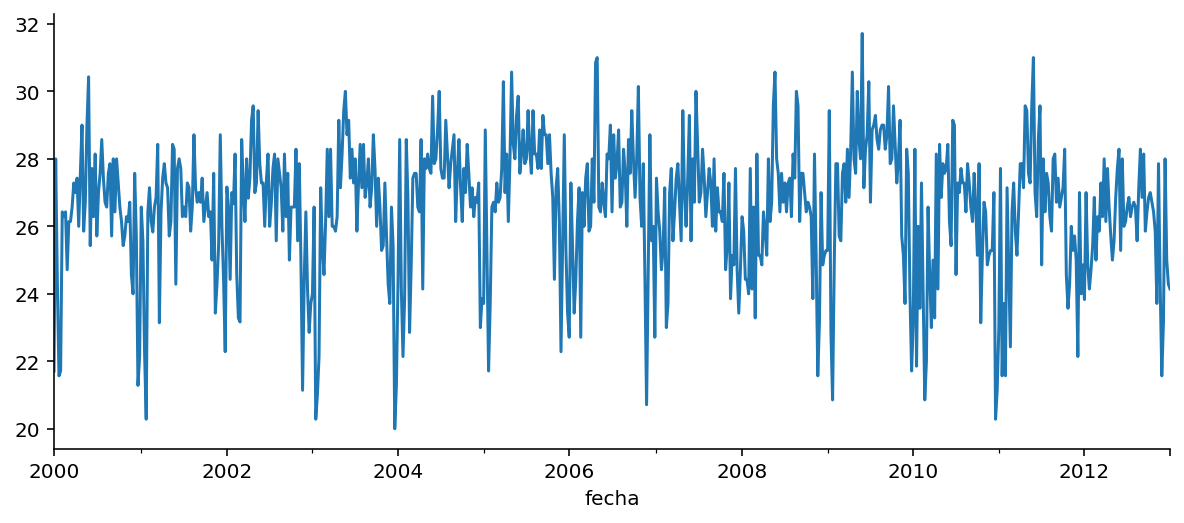

In [45]:
temp_media["2000":"2012"].plot()

## Autocorrelación

$$
    \text{Corr}(S_t, S_{t-\tau})
$$

In [52]:
lagged_ts = ts_utils.ts_supervised(pd.DataFrame(temp_media), n_in=52)b

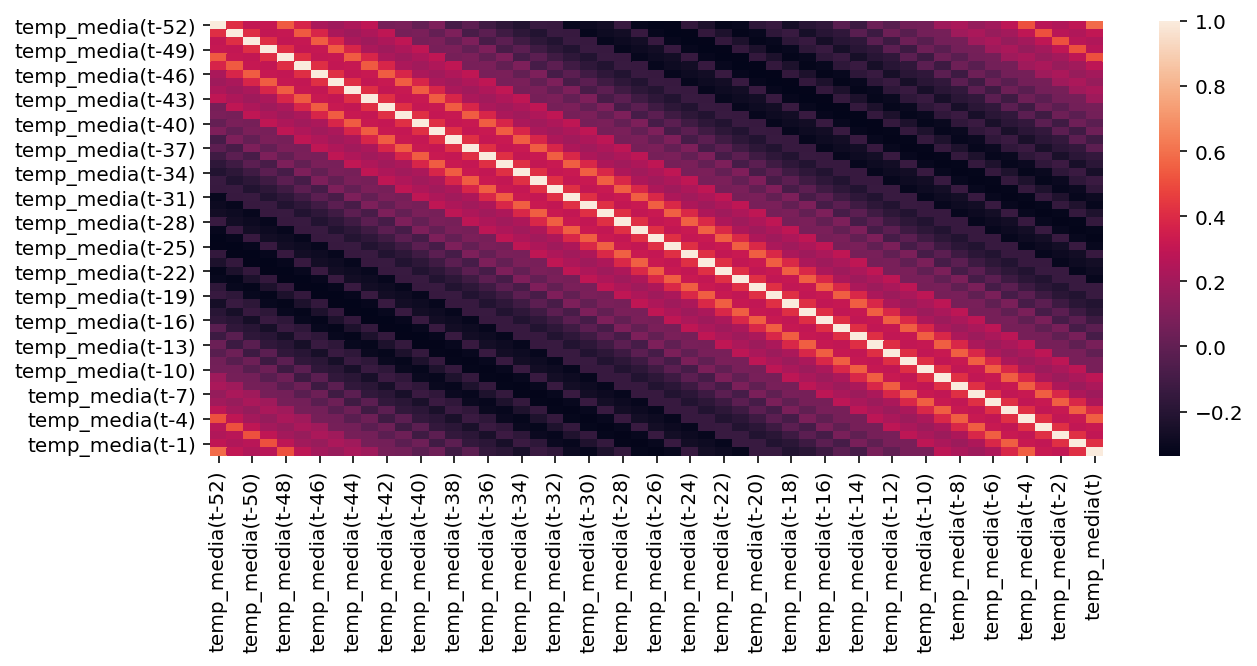

In [62]:
sns.heatmap(lagged_ts.corr());

In [67]:
from statsmodels.graphics.tsaplots import plot_acf

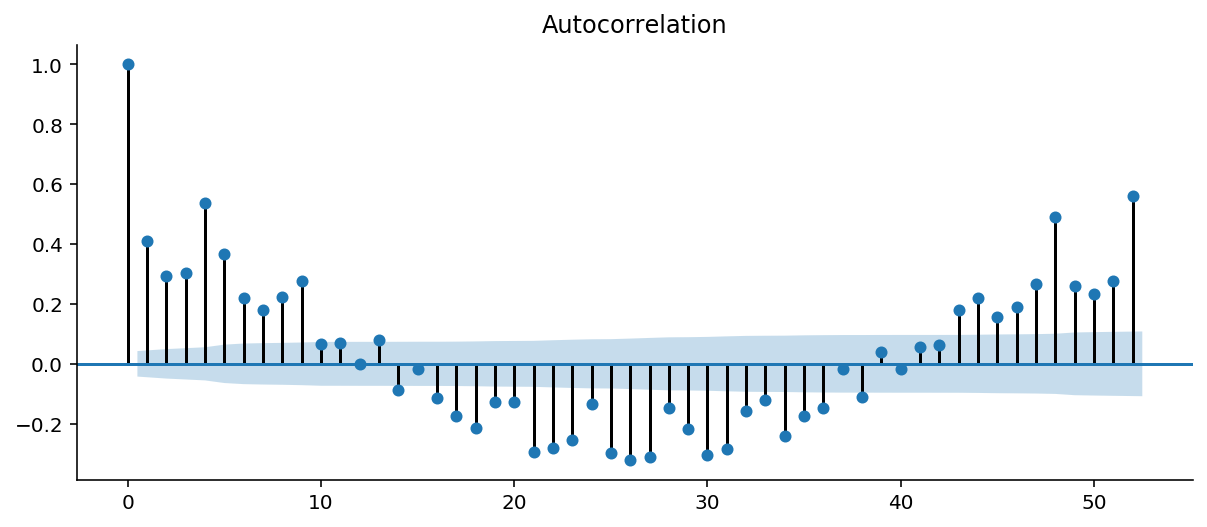

In [70]:
# Grafica de la autocorrelación
plot_acf(temp_media.ffill(), lags=52);

In [90]:
corr_min = lagged_ts.corr()["temp_media(t)"].idxmin()
corr_max = lagged_ts.corr()["temp_media(t)"][:-1].idxmax()

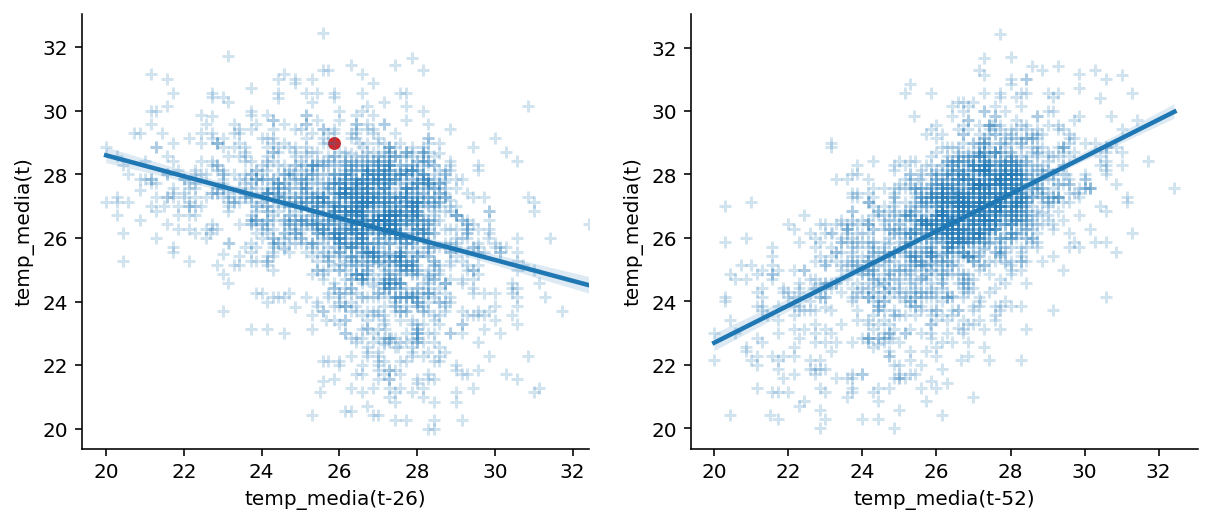

In [116]:
fig, ax = plt.subplots(1, 2)

ax[0].scatter(*lagged_ts[[corr_min, "temp_media(t)"]].iloc[-1], c="tab:red", s=30)
sns.regplot(x=corr_min, y="temp_media(t)", data=lagged_ts, scatter_kws={"alpha": 0.2}, marker="+", ax=ax[0])
sns.regplot(x=corr_max, y="temp_media(t)", data=lagged_ts, scatter_kws={"alpha": 0.2}, marker="+", ax=ax[1])

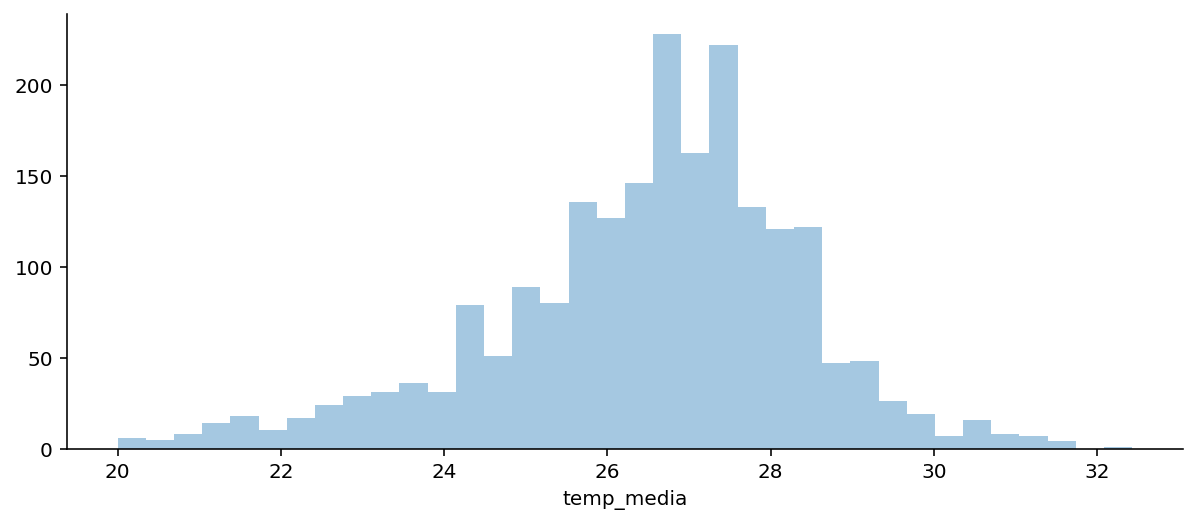

In [101]:
sns.distplot(temp_media, kde=False);

## La prueba de ADF (Augmented Dickey Fuller)

In [102]:
from statsmodels.tsa.stattools import adfuller

$$
    \Delta S_t = \alpha + \beta t + \gamma S_{t-1} + \sum_{\tau=1}^p \delta_{\tau}\Delta S_{t-\tau} + \epsilon_t
$$

$$
    H_0: \gamma = 0\\
    H_1: \gamma < 0
$$

In [104]:
# regression = "c" => beta = 0
adf, pval, used_lags, nobs, critical_vals, icbest = adfuller(temp_media.ffill().values, 52, regression="c")

In [105]:
pval

0.016056847389719152

# AR(1)

$$
    S_t \vert S_{t-1} \sim \mathcal{N}\left(\phi S_{t-1} + \psi, \sigma^2\right)
$$

Estimamos $\phi$, $\psi$, $\sigma^2$ por máxima verosimilitud

$$
    \hat\sigma^2 = \frac{1}{T}\left[(1 - \phi^2)\left(S_1 - \frac{\psi}{1 - \phi}\right)^2 + \sum_{t=2}^T(S_t - \phi S_{t-1} - \psi)^2\right]
$$

$$
    \log p({\bf S}\vert \psi, \phi) = \frac{1}{2}\log(1 - \phi^2) - \frac{T}{2}\log \hat\sigma^2 - \frac{T}{2}
$$

In [143]:
from scipy.optimize import minimize

In [155]:
def get_sigma2_ml(phi, psi, S):
    mu = psi / (1 - phi)
    S1 = S.iloc[0] - mu
    T = len(S)
    S_offset = ts_utils.ts_supervised(pd.DataFrame(S))
    
    dispertion = np.sum((S_offset.iloc[:, 1] - phi * S_offset.iloc[:, 0] - psi) ** 2)
    sigma2_ml = ((1 - phi ** 2) * S1 ** 2 + dispertion) / T
    
    return sigma2_ml

def AR1(phi, psi, S):
    T = len(S)    
    sigma2_ml = get_sigma2_ml(phi, psi, S)
    
    log_likelihood = np.log(1 - phi ** 2) / 2 - T * np.log(sigma2_ml) / 2
    
    return -log_likelihood / 100

In [156]:
AR1(phi0, psi0, temp_media)

69.32813119140943

In [ ]:
temp_media_train = temp_media[:"2019"]
temp_media_test = temp_media["2020"]

In [163]:
phi0, psi0 = 0, 0


f = minimize(lambda x: AR1(x[0], x[1], temp_media_train.ffill()),
             (phi0, psi0),
              method="L-BFGS-B")

f

      fun: 11.392122118664897
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00000000e+00, -1.77635684e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 75
      nit: 18
   status: 0
  success: True
        x: array([ 0.40782567, 15.67052931])

In [164]:
phi, psi = f.x

In [165]:
# E[St]
psi / (1 - phi)

26.4626961597141

In [166]:
phi

0.40782567225931216

### Ocupando una librería

In [179]:
from statsmodels.tsa.arima_model import ARMA

ar1 = ARMA(temp_media_train.ffill(), (10, 0))
ar1 = ar1.fit(start_start=(0, 0))
ar1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             temp_media   No. Observations:                 2087
Model:                    ARMA(10, 0)   Log Likelihood               -3770.265
Method:                       css-mle   S.D. of innovations              1.473
Date:                Wed, 29 Jul 2020   AIC                           7564.529
Time:                        20:28:50   BIC                           7632.251
Sample:                    01-06-1980   HQIC                          7589.342
                         - 12-29-2019                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                26.4558      0.109    242.522      0.000      26.242      26.670
ar.L1.temp_media      0.2400      0.022     11.108      0.000       0.198       0.282
ar.L2.temp_media      0.0608      0.022      2.758      0.006       0.018       0.104
ar.L3.temp_media      0.0581      0.022      2.643      0.008       0.015       0.101
ar.L4.temp_media      0.4531      0.022     20.573      0.000       0.410       0.496
ar.L5.temp_media      0.0440      0.024      1.821      0.069      -0.003       0.091
ar.L6.temp_media      0.0250      0.024      1.034      0.301      -0.022       0.072
ar.L7.temp_media     -0.0271      0.022     -1.226      0.220      -0.070       0.016
ar.L8.temp_media     -0.1022      0.022     -4.635      0.000      -0.145      -0.059
ar.L9.temp_media      0.1231      0.022      5.562      0.000       0.080       0.167
ar.L10.temp_media    -0.1700      0.022     -7.842      0.000      -0.213      -0.128
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1            -1.0810           -0.3121j            1.1251           -0.4553
AR.2            -1.0810           +0.3121j            1.1251            0.4553
AR.3            -0.5927           -1.0660j            1.2197           -0.3308
AR.4            -0.5927           +1.0660j            1.2197            0.3308
AR.5             0.1148           -1.1154j            1.1213           -0.2337
AR.6             0.1148           +1.1154j            1.1213            0.2337
AR.7             1.1350           -0.1466j            1.1444           -0.0204
AR.8             1.1350           +0.1466j            1.1444            0.0204
AR.9             0.7860           -1.1308j            1.3771           -0.1533
AR.10            0.7860           +1.1308j            1.3771            0.1533
------------------------------------------------------------------------------
"""

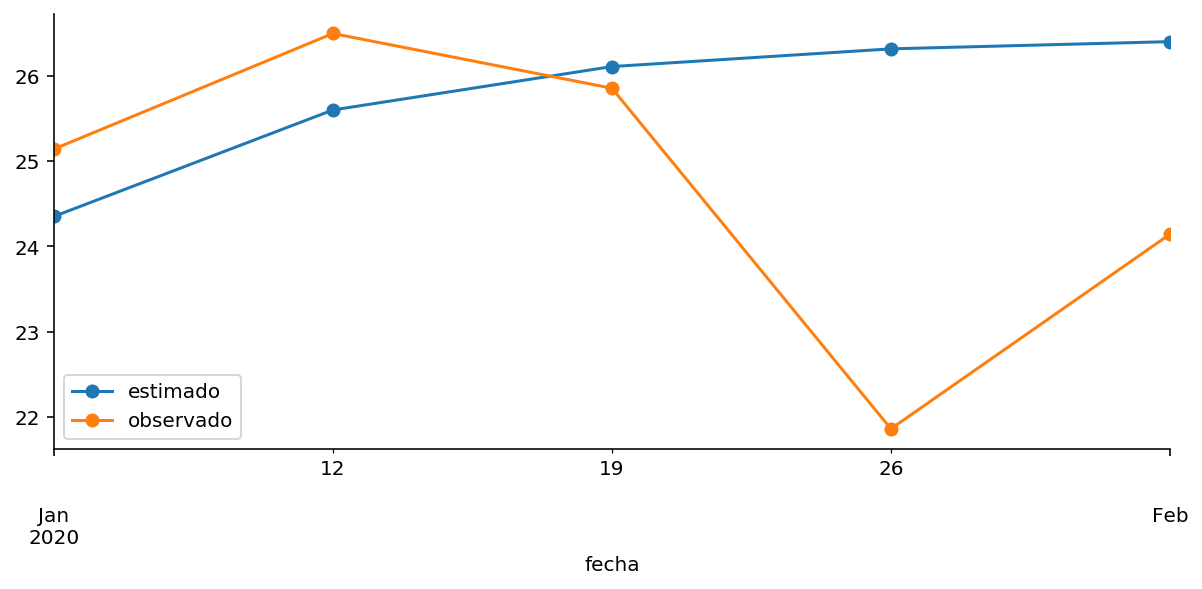

In [178]:
init_date = "2020-01-01"
end_date = "2020-02-02"


ar1.predict(start=init_date, end=end_date).plot(marker="o", label="estimado")
temp_media_test[:end_date].plot(marker="o", label="observado")
plt.legend()

* BIC (Bayes Information Criterion)
* Cross Validation

## AR(p)

$$
    S_t \vert S_{t-1}, \ldots, S_{t-p} \sim \mathcal{N}\left(\psi + \sum_{\tau=1}^p \phi_\tau S_{t - \tau}, \sigma^2\right)
$$

In [188]:
init_date = temp_media_test.index[0]
end_date = temp_media_test.index[-1]

In [213]:
from tqdm.notebook import tqdm

In [214]:
list_bic = []
list_mae = []

ar_params =  np.arange(1, 25)
for p in tqdm(ar_params):
    arma = ARMA(temp_media_train.ffill(), (p, 0)).fit()
    bic = arma.bic

    temp_est = arma.predict(init_date, end_date)
    # MAE: Mean Absolute Error
    mae = pd.concat([temp_media_test, temp_est], axis=1).diff(axis=1)[0].abs().mean()
    
    list_bic.append(bic)
    list_mae.append(mae)

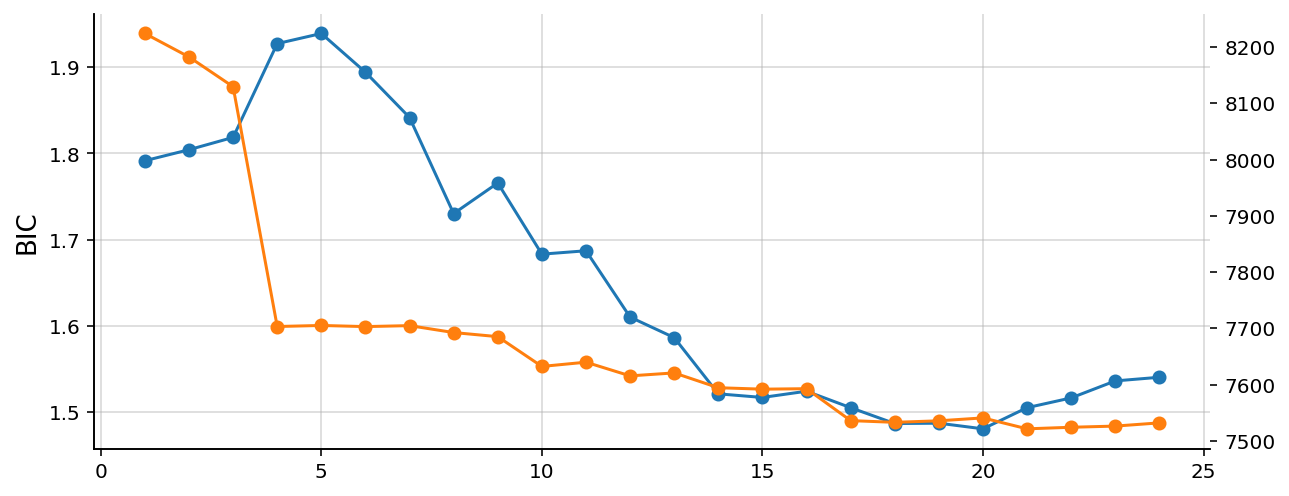

In [224]:
fig, ax = plt.subplots()
ax2 = ax.twinx()

ax.plot(ar_params, list_mae, marker="o", label="MAE")
ax2.plot(ar_params, list_bic, marker="o", label="BIC", c="tab:orange")
ax.set_ylabel("MAE", fontsize=13)
ax.set_ylabel("BIC", fontsize=13)
ax.grid(alpha=0.5)

In [226]:
ar_params[np.argmin(list_bic)]

21

In [227]:
ar_params[np.argmin(list_mae)]

20